# **GAN, CGAN**

## **필요한 라이브러리 설치**

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import gdown
import zipfile
import requests
import tqdm

# 하이퍼파라미터 설정
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.

## **데이터 다운로드 및 파라미터 설정**

In [ ]:
dataroot = "./data"
workers = 2
batch_size = 128
image_size = 32
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.0002
beta1 = 0.5
ngpu = 1
num_classes = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터 변환 및 로드
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = dset.CIFAR100(root=dataroot, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

Files already downloaded and verified


## **가중치 초기화**

In [ ]:
# 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and m.weight is not None:
        if classname.find("Conv") != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

## **GAN 함수 정의**

In [ ]:
# 생성자 정의
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),  # (ngf*4) x 4 x 4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # (ngf*2) x 8 x 8
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # (ngf) x 16 x 16
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # (nc) x 32 x 32
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator(ngpu).to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
# 구분자 정의
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [ ]:
# 손실 함수 및 옵티마이저
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## **GAN 학습**

In [ ]:
# 학습 루프
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # 구분자 학습
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # 생성자 학습
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

print("Training Finished!")

Starting Training Loop...
[1/50][0/391] Loss_D: 0.2474 Loss_G: 5.6868 D(x): 0.8673 D(G(z)): 0.0810/0.0050
[1/50][50/391] Loss_D: 0.1107 Loss_G: 4.9502 D(x): 0.9340 D(G(z)): 0.0338/0.0095
[1/50][100/391] Loss_D: 0.5895 Loss_G: 3.8519 D(x): 0.8370 D(G(z)): 0.3002/0.0308
[1/50][150/391] Loss_D: 0.4143 Loss_G: 3.5638 D(x): 0.7723 D(G(z)): 0.1204/0.0372
[1/50][200/391] Loss_D: 0.9315 Loss_G: 5.1154 D(x): 0.8718 D(G(z)): 0.4814/0.0215
[1/50][250/391] Loss_D: 0.4880 Loss_G: 2.8429 D(x): 0.7147 D(G(z)): 0.0654/0.0835
[1/50][300/391] Loss_D: 0.6139 Loss_G: 1.6370 D(x): 0.6619 D(G(z)): 0.1250/0.2357
[1/50][350/391] Loss_D: 0.2557 Loss_G: 3.0160 D(x): 0.9090 D(G(z)): 0.1360/0.0635
[2/50][0/391] Loss_D: 0.5484 Loss_G: 4.1505 D(x): 0.8512 D(G(z)): 0.2654/0.0344
[2/50][50/391] Loss_D: 0.4545 Loss_G: 4.1573 D(x): 0.8714 D(G(z)): 0.2456/0.0227
[2/50][100/391] Loss_D: 0.5720 Loss_G: 3.5626 D(x): 0.8344 D(G(z)): 0.2764/0.0409
[2/50][150/391] Loss_D: 0.4141 Loss_G: 3.2009 D(x): 0.8221 D(G(z)): 0.1692/0.0

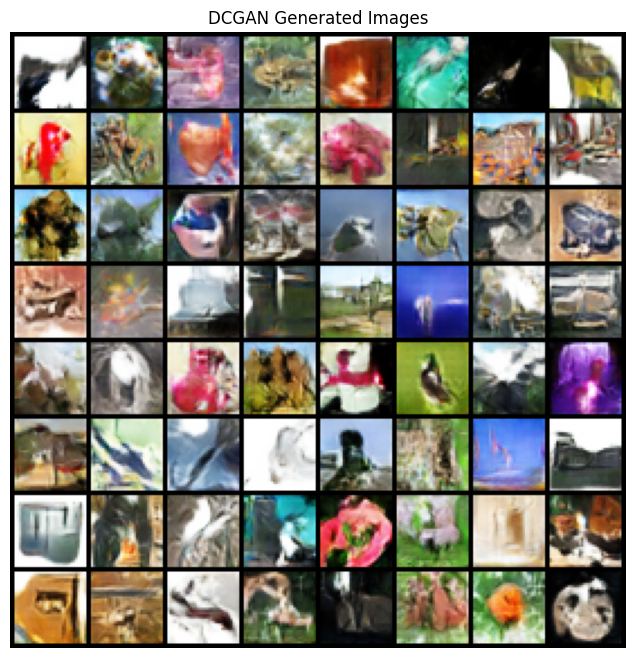

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# DCGAN 이미지 생성
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    fake_dcgan = netG(fixed_noise).detach().cpu()

# DCGAN 이미지 시각화
plt.figure(figsize=(8, 8))
plt.imshow(vutils.make_grid(fake_dcgan, padding=2, normalize=True).permute(1, 2, 0))
plt.title("DCGAN Generated Images")
plt.axis("off")
plt.show()

## **CGAN 함수 정의**

In [ ]:
# CGAN Generator
class CGAN_Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes):
        super(CGAN_Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)  # 각 라벨별로 nz개의 임베당 차원을 가짐

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz * 2, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # [batch, nz, 1, 1]
        input = torch.cat([noise, label_embedding], 1)  # [batch, 2*nz, 1, 1]
        return self.main(input)

# 모델 초기화
netG_cgan = CGAN_Generator(nz, ngf, nc, num_classes).to(device)
netG_cgan.apply(weights_init)

CGAN_Generator(
  (label_emb): Embedding(100, 100)
  (main): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
# CGAN Discriminator
class CGAN_Discriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes, image_size):
        super(CGAN_Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, image_size * image_size)  # 각 라벨별로 input image 사이즈와 동일한 임베딩을 가짐

        self.main = nn.Sequential(
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input, labels):
        label_embedding = self.label_emb(labels).view(labels.shape[0], 1, image_size, image_size)  # [batch, 1, 32, 32]
        input = torch.cat([input, label_embedding], 1)  # 이미지와 라벨을 채널 차원에서 결합
        return self.main(input)

netD_cgan = CGAN_Discriminator(nc, ndf, num_classes, image_size).to(device)
netD_cgan.apply(weights_init)

CGAN_Discriminator(
  (label_emb): Embedding(100, 1024)
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [ ]:
# 손실 함수 및 옵티마이저
criterion = nn.BCELoss()
optimizerD_cgan = optim.Adam(netD_cgan.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG_cgan = optim.Adam(netG_cgan.parameters(), lr=lr, betas=(beta1, 0.999))

## **CGAN 학습**

In [ ]:
# CGAN 학습 루프
print("Starting CGAN Training Loop...")
for epoch in range(num_epochs):
    for i, (real_cpu, labels) in enumerate(dataloader, 0):
        netD_cgan.zero_grad()
        real_cpu = real_cpu.to(device)
        labels = labels.to(device)
        b_size = real_cpu.size(0)

        real_label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), 0., dtype=torch.float, device=device)

        output = netD_cgan(real_cpu, labels).view(-1)
        errD_real = criterion(output, real_label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG_cgan(noise, labels)
        output = netD_cgan(fake.detach(), labels).view(-1)
        errD_fake = criterion(output, fake_label)
        errD_fake.backward()
        optimizerD_cgan.step()

        netG_cgan.zero_grad()
        output = netD_cgan(fake, labels).view(-1)
        errG = criterion(output, real_label)
        errG.backward()
        optimizerG_cgan.step()

        if i % 50 == 0:
            print(f'[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real.item()+errD_fake.item():.4f} Loss_G: {errG.item():.4f}')

Starting CGAN Training Loop...
[1/50][0/391] Loss_D: 1.6001 Loss_G: 1.4921
[1/50][50/391] Loss_D: 0.8652 Loss_G: 4.8491
[1/50][100/391] Loss_D: 1.0327 Loss_G: 1.9073
[1/50][150/391] Loss_D: 0.5587 Loss_G: 4.2608
[1/50][200/391] Loss_D: 0.9587 Loss_G: 1.9991
[1/50][250/391] Loss_D: 0.9348 Loss_G: 1.7581
[1/50][300/391] Loss_D: 1.0344 Loss_G: 2.3339
[1/50][350/391] Loss_D: 0.7895 Loss_G: 2.0292
[2/50][0/391] Loss_D: 1.1471 Loss_G: 2.0829
[2/50][50/391] Loss_D: 1.0251 Loss_G: 1.9143
[2/50][100/391] Loss_D: 0.9603 Loss_G: 1.8944
[2/50][150/391] Loss_D: 1.2293 Loss_G: 1.5386
[2/50][200/391] Loss_D: 1.1766 Loss_G: 1.7131
[2/50][250/391] Loss_D: 0.9646 Loss_G: 1.9457
[2/50][300/391] Loss_D: 1.0275 Loss_G: 1.9797
[2/50][350/391] Loss_D: 1.3339 Loss_G: 1.4596
[3/50][0/391] Loss_D: 1.0301 Loss_G: 1.8130
[3/50][50/391] Loss_D: 1.1705 Loss_G: 1.5314
[3/50][100/391] Loss_D: 1.2394 Loss_G: 1.4533
[3/50][150/391] Loss_D: 1.1218 Loss_G: 1.7037
[3/50][200/391] Loss_D: 1.2054 Loss_G: 1.4210
[3/50][250/3

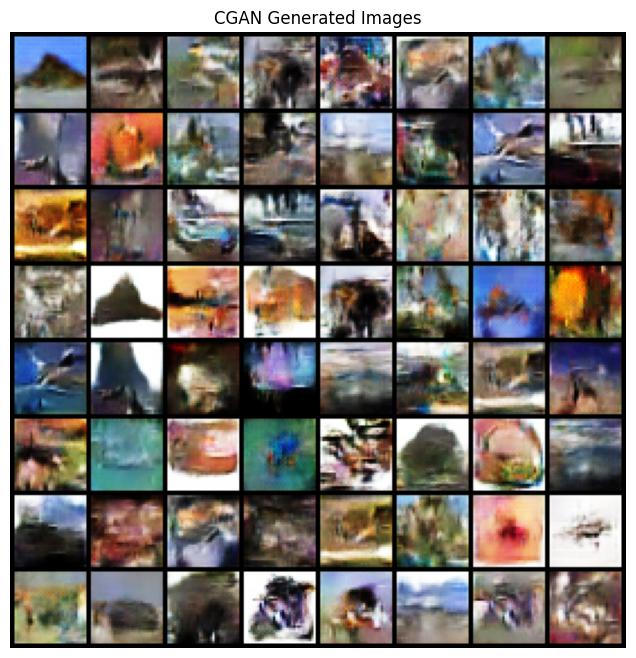

In [ ]:
# CGAN 이미지 생성 및 시각화
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

with torch.no_grad():
    fake_cgan = netG_cgan(fixed_noise, fixed_labels).detach().cpu()

plt.figure(figsize=(8, 8))
plt.imshow(vutils.make_grid(fake_cgan, padding=2, normalize=True).permute(1, 2, 0))
plt.title("CGAN Generated Images")
plt.axis("off")
plt.show()

## **분석 및 고찰**

### **MLP 대신 Conv를 선택한 이유**
CIFAR-100과 같은 이미지 데이터셋을 학습할 때, MLP보다 CNN이 더욱 효과적인 특징 학습을 수행할 수 있습니다. 따라서, CIFAR-100을 학습하는 데 있어 **MLP보다 Conv 기반 모델이 적절하다고 판단**하여 DCGAN을 선택하였습니다. 동일한 설정을 위해 Conditional GAN에도 Conv연산을 수행하여 학습을 진행하였습니다.

### **GAN과 CGAN의 차이**
##### **GAN**
- Generator(G)는 노이즈(z)를 입력받아 이미지를 생성
- Discriminator(D)는 진짜 이미지와 가짜 이미지를 입력받아 판별
- D는 진짜 이미지를 1, 가짜 이미지를 0으로 판별하도록 학습
- G는 D(G(z))가 1이 되도록 학습
- **G (input: nz(임베딩 차원), output: 원본 이미지 사이즈)**
- **D (input: 원본 이미지 사이즈, output: 0/1)**

##### **CGAN**
- G는 노이즈(z) + 라벨 임베딩을 입력받아 이미지를 생성
- D는 이미지 + 라벨 임베딩을 추가한 입력을 받아 진짜/가짜를 판별
- D는 해당 라벨의 진짜 이미지를 1, 가짜 이미지를 0으로 판별하도록 학습
- G는 D(G(z), label)이 1이 되도록 학습
- **G (input: 2*nz (z + 라벨 임베딩), output: 원본 이미지 사이즈)**
- **D (input: 2*image_size (원본 이미지 + 라벨 임베딩), output: 0/1)**

### **학습 과정**

#### **구분자(Discriminator) 학습**

##### **Step 1: 진짜 데이터(real) 학습**
  - 진짜 데이터로 이루어진 배치를 생성하고 Discriminator에 입력합니다.
  - Discriminator의 출력값을 사용하여 손실값 log(D(x)) 을 계산합니다.

##### **Step 2: 가짜 데이터(fake) 학습**
  - 가짜 데이터로 이루어진 배치를 생성한 후, Discriminator에 입력합니다.
  - Discriminator의 출력값을 사용하여 손실값 log(1−D(G(z)))을 계산합니다.

##### **Step 3: 구분자(Discriminator) 업데이트**
  - 위 두 단계를 통해 계산된 gradient를 통해, 구분자(Discriminator)를 업데이트합니다.

#### **생성자(Generator) 학습**

##### **Step 1: 가짜 데이터(fake) 학습**
  - 랜덤 노이즈 (z)를 입력으로 하여 생성자 (Generator)를 통해 가짜 데이터를 생성합니다.
  - 생성된 가짜 데이터를 구분자 (Discriminator)에 입력합니다.
  - **구분자(Discriminator)가 가짜 데이터를 진짜라고 판단하도록** 학습해야 합니다.
  - 따라서, 손실 함수는 log(D(G(z)))를 최대화하는 방향으로 설정됩니다.

##### **Step 2: 생성자(Generator) 업데이트**
  - 구분자 (Discriminator)의 기울기는 고정하고, 생성자 (Generator)의 기울기만 업데이트합니다.
  - 최적화 과정을 수행하여 생성자가 더욱 진짜 같은 데이터를 만들도록 학습시킵니다.

### **학습 결과 분석**
#### **GAN**
- D(x)가 1에서 학습하면 할수록 0.5에 가까워지는 것을 볼 수 있었으며, D(G(z))는 0에서부터 0.5에 가까워지는 것을 볼 수 있었습니다.
- 실제 학습이 올바르게 진행되지 않아 의미 있는 이미지를 생성하지는 못했지만, 원본과 유사한 형태의 이미지를 생성하려는 경향은 확인할 수 있었습니다.

#### **CGAN**
- CGAN의 학습이 제대로 진행되지 않아 의미 있는 이미지를 생성하지 못했습니다.
- CGAN은 조건(condition) 정보를 반영해야 하므로, 일반 GAN보다 더 많은 epoch가 필요할 것으로 예상됩니다.
- 또한, 생성자보다 판별자를 여러 번 학습시키는 과정이 없었기 때문에 학습이 원활하게 진행되지 않았을 가능성이 큽니다.
- 기존 Batch normalization 대신, Conditional Batch Normalization을 사용하는 방법도 있을 것입니다.  - BN은 모든 데이터에 대해 동일한 β, γ를 사용하지만, CBN은 y별로 다른 β, γ를 사용하여 Generator가 조건을 보다 잘 반영할 수 있도록 합니다.